# Anomaly detection for clickstream data

## SageMaker Random Cut Forest 

In [1]:
%store -r urls url_new css streams

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import boto3
import botocore
import sagemaker
import sys

### Data resampling

We will use aggagated timeseries with 3 features of the number of visited urls, the number of visitors, and the numbor of clicks in 1 minute.

In [3]:
r = css.set_index('timestamp').resample('1T')
s = r.nunique()[['url','user_session_id']]
s['clicks'] = r.count()['clickstream_id']
s.columns = ['urls','users','clicks']
s.head()

,urls,users,clicks
timestamp,,,
2012-03-01 00:00:00,3,4,5
2012-03-01 00:01:00,2,3,4
2012-03-01 00:02:00,1,4,4
2012-03-01 00:03:00,4,4,5
2012-03-01 00:04:00,5,6,9


- Plot the series

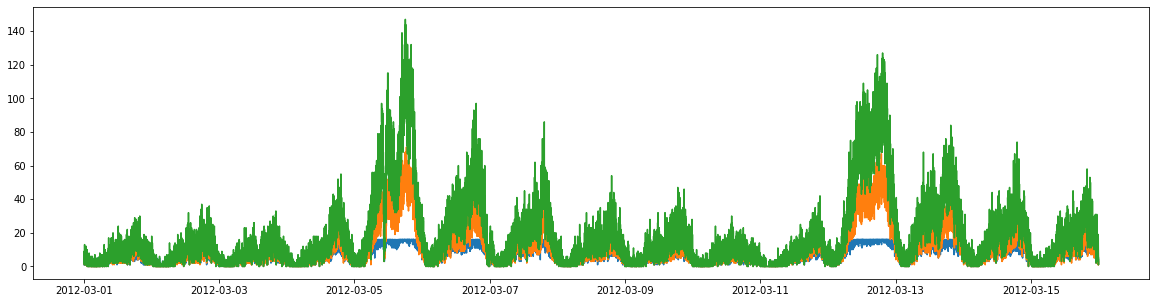

In [5]:
plt.figure(figsize=(20,5))
plt.plot(s)
plt.show()

### RCF Training

Then train the model with SageMaker built-in RandomCutForest algorithm

In [6]:
from sagemaker import RandomCutForest

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'rcf-clickstream'
execution_role = sagemaker.get_execution_role()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(s.to_numpy()))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-16 12:54:52 Starting - Starting the training job...
2020-08-16 12:54:54 Starting - Launching requested ML instances......
2020-08-16 12:56:08 Starting - Preparing the instances for training......
2020-08-16 12:57:08 Downloading - Downloading input data...
2020-08-16 12:57:24 Training - Downloading the training image......
2020-08-16 12:58:49 Uploading - Uploading generated training model
2020-08-16 12:58:49 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators impo

In [ ]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------

### Prediction (Getting anomaly scores)

Set the serializer and predict the anomaly score.

In [12]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [13]:
results = rcf_inference.predict(s.to_numpy())

Let's look at the distribution of our anomaly score.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd84e372e8>]],
      dtype=object)

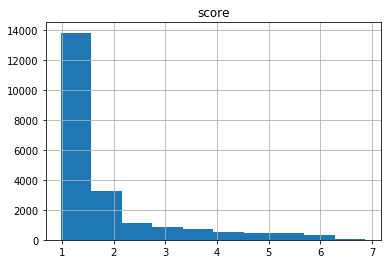

In [14]:
results_pd = pd.DataFrame(results['scores'])
results_pd.hist()

### Check the result

We can find the algorthim is detecting anomalies with the change and deviation of each feature value instead of using a fixed threshold.

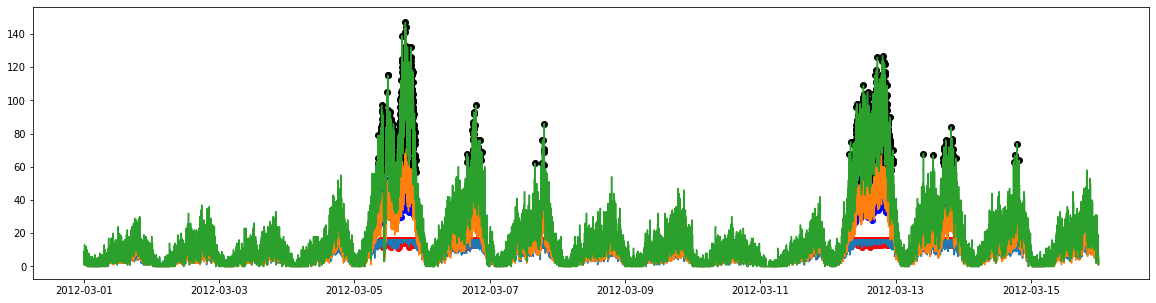

In [18]:
plt.figure(figsize=(20,5))
plt.plot(s)
threshold = 4.5
anomalous = s[list((results_pd > threshold)['score'])]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.show()

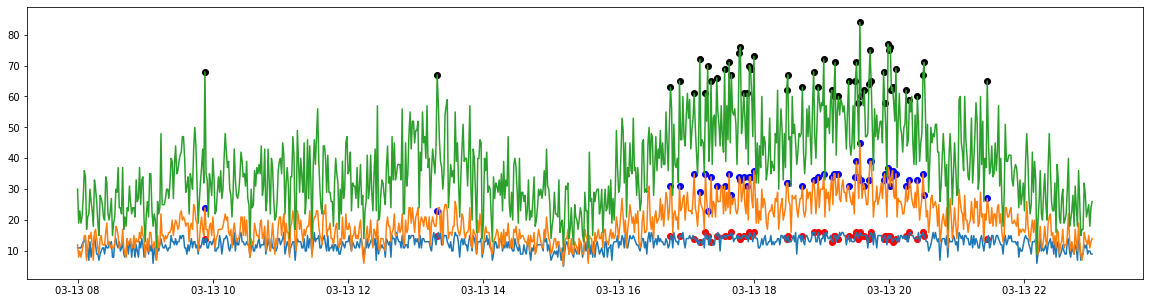

In [19]:
plt.figure(figsize=(20,5))
plt.plot(s["2012-03-13 08:00:00":"2012-03-13 23:00:00"])
threshold = 4.5
anomalous = s[list((results_pd > threshold)['score'])]["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.show()

To examine the relationship between anomaly scores and feature deviations more intuitively, let's plot the the residuals of clicks and users. Below graph show this changes. We can understand anomly socres were returned not only by residual or just the amount of the value. 

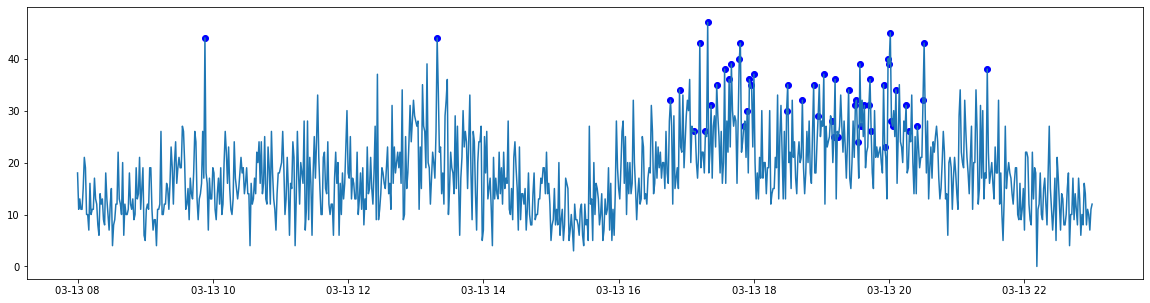

In [21]:
plt.figure(figsize=(20,5))
plt.plot(s['clicks']-s['users']["2012-03-13 08:00:00":"2012-03-13 23:00:00"])
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values - anomalous['users'].values, c='blue')
plt.show()

Zoom in arount 6th March again.

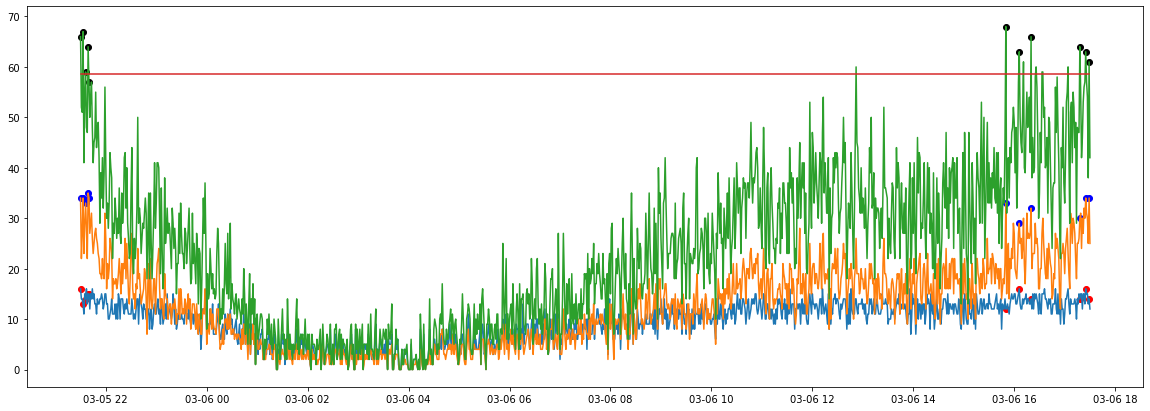

In [22]:
plt.figure(figsize=(20,7))
plt.plot(s["2012-03-05 21:30:00":"2012-03-06 17:30:00"])
threshold = 4.5
anomalous = s[list((results_pd > threshold)['score'])]["2012-03-05 21:30:00":"2012-03-06 17:30:00"]
plt.scatter(x= anomalous.index, y=anomalous['urls'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['users'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values, c='black')
plt.plot(pd.DataFrame([58.5]*len(anomalous.index)).set_index(anomalous.index))
plt.show()

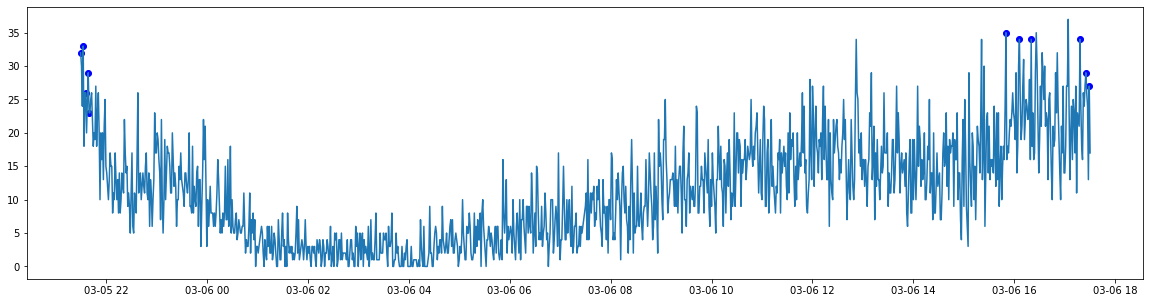

In [23]:
plt.figure(figsize=(20,5))
plt.plot(s['clicks']-s['users']["2012-03-05 21:30:00":"2012-03-06 17:30:00"])
plt.scatter(x= anomalous.index, y=anomalous['clicks'].values - anomalous['users'].values, c='blue')
plt.show()